Using xgboost or a random forest regressor to determine relevant features

In [1]:
strat_univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

In [2]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [97]:
data_freq = '4h'
day_periods = 6

look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
in_sample_end_datetime = pd.to_datetime('2022-08-05 04:00:00')
# in_sample_end_datetime = pd.to_datetime('2023-12-31 20:00:00')

In [98]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for ADAUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XRPUSDT.
Downloaded data for DOTUSDT.
Downloaded data for MATICUSDT.


In [143]:
import numpy as np

def get_signals(price_volume_df):
    coin_signals = pd.DataFrame(0.0, columns = [], index=price_volume_df.index)

    coin_signals["price-1"] = price_volume_df["close"].shift()
    coin_signals["price-2"] = price_volume_df["close"].shift(2)
    coin_signals["log price-1"] = np.log(coin_signals["price-1"])
    coin_signals["log price-2"] = np.log(coin_signals["price-2"])
    coin_signals["price-1 - price-2"] = coin_signals["price-1"] - coin_signals["price-2"]
    coin_signals["price change rate"] = coin_signals["price-1"] / coin_signals["price-2"] - 1
    coin_signals["log price quotient"] = np.log(coin_signals["price-1"] / coin_signals["price-2"])

    coin_signals["volume-1"] = price_volume_df["volume"].shift()
    coin_signals.loc[coin_signals["volume-1"] == 0,"volume-1"] = 0.001
    coin_signals["volume-2"] = price_volume_df["volume"].shift(2)
    coin_signals.loc[coin_signals["volume-2"] == 0,"volume-2"] = 0.001
    coin_signals["log volume-1"] = np.log(coin_signals["volume-1"])
    #coin_signals["log volume-1"][coin_signals["log volume-1"] == float('-inf')] = 0.001
    coin_signals["log volume-2"] = np.log(coin_signals["volume-2"])
    #coin_signals["log volume-2"][coin_signals["log volume-2"] == float('-inf')] = 0.001
    coin_signals["volume-1 - volume-2"] = coin_signals["volume-1"] - coin_signals["volume-2"]
    coin_signals["volume change rate"] = coin_signals["volume-1"] / coin_signals["volume-2"] - 1
    coin_signals["log volume quotient"] = np.log(coin_signals["volume-1"] / coin_signals["volume-2"])
    #coin_signals["log volume quotient"][coin_signals["log volume quotient"] == float('-inf')] = -10.0

    price_columns = [
        "price-1", "price-2", "log price-1", "log price-2", "price-1 - price-2", "price change rate",
        "log price quotient"]

    volume_columns = [
        "volume-1", "volume-2", "log volume-1", "log volume-2", "volume-1 - volume-2", "volume change rate",
        "log volume quotient"
    ]

    for p_col in price_columns:
        for v_col in volume_columns:
            coin_signals[p_col + " x " + v_col] = coin_signals[p_col] * coin_signals[v_col]
    
    return coin_signals


def get_signals_for_all_coins(px_data):
    coin_to_signals = dict()

    for coin in px_data:
        #price_volume_df = px_data[coin][["close", "volume"]].astype(float)
        price_volume_df = px_data[coin][
            ["close", "quote_volume"]].rename({"quote_volume": "volume"}, axis=1).astype(float)
        coin_to_signals[coin] = get_signals(price_volume_df)
    
    return coin_to_signals

In [144]:
px_data['BTCUSDT']['close']

open_time
2020-01-01 00:00:00     7205.50000000
2020-01-01 08:00:00     7233.02000000
2020-01-01 16:00:00     7195.65000000
2020-01-02 00:00:00     7114.66000000
2020-01-02 08:00:00     7131.26000000
                            ...      
2025-03-07 08:00:00    88341.54000000
2025-03-07 16:00:00    86791.40000000
2025-03-08 00:00:00    86221.43000000
2025-03-08 08:00:00    86500.00000000
2025-03-08 16:00:00    86167.67000000
Name: close, Length: 5682, dtype: object

In [145]:
m = len(px_data['BTCUSDT'].index)
px_data['BTCUSDT'].index[int(m * 0.5)]


Timestamp('2022-08-05 00:00:00')

In [146]:
from sklearn.ensemble import RandomForestRegressor

coin_to_signals = get_signals_for_all_coins(px_data)
coin_to_rfr_model = dict()

for coin, signals in coin_to_signals.items():
    rfr_model = RandomForestRegressor(random_state=836)
    
    in_sample_signals = signals.iloc[2:].loc[:in_sample_end_datetime]
    in_sample_close_price = px_data[coin]['close'].iloc[2:].loc[:in_sample_end_datetime]
    
    rfr_model.fit(in_sample_signals, in_sample_close_price)
    coin_to_rfr_model[coin] = rfr_model
    print(f"Model fitted for {coin}.")

Model fitted for BTCUSDT.
Model fitted for ETHUSDT.
Model fitted for ADAUSDT.
Model fitted for BNBUSDT.
Model fitted for XRPUSDT.
Model fitted for DOTUSDT.
Model fitted for MATICUSDT.


In [149]:
coin_to_rfr_model['BTCUSDT']

RandomForestRegressor(random_state=836)

<Axes: xlabel='open_time'>

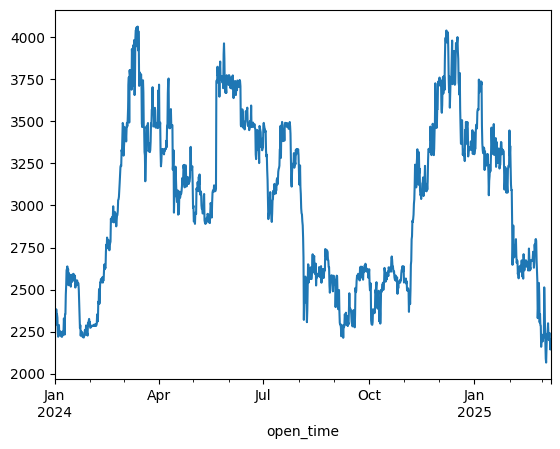

In [150]:
from datetime import timedelta

out_sample_start_datetime = in_sample_end_datetime + timedelta(hours=4)
eth_signals_out_sample = coin_to_signals['ETHUSDT'].loc[out_sample_start_datetime:]
eth_out_sample_predictions = coin_to_rfr_model['ETHUSDT'].predict(eth_signals_out_sample)
eth_out_sample_predictions = pd.Series(eth_out_sample_predictions, index=eth_signals_out_sample.index)

eth_out_sample_predictions.plot()

<Axes: xlabel='open_time'>

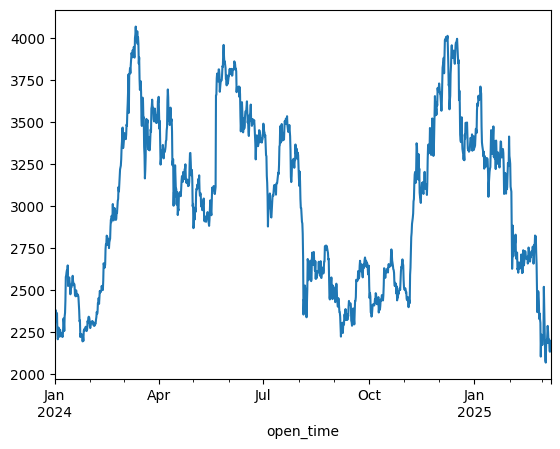

In [151]:
eth_price = px_data['ETHUSDT'].loc[out_sample_start_datetime:]['close'].astype(float)
eth_price.plot()

<Axes: xlabel='open_time'>

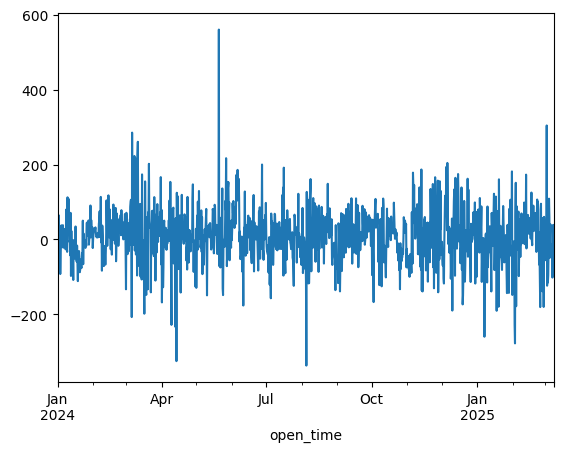

In [152]:
(eth_price - eth_out_sample_predictions).plot()

In [153]:
(eth_price - eth_out_sample_predictions).mean()

9.07323441108545

In [154]:
eth_residuals = eth_price - eth_out_sample_predictions
mean = eth_residuals.mean()
std = eth_residuals.std()

(eth_residuals - mean) / std

open_time
2024-01-01 00:00:00   -0.182154
2024-01-01 08:00:00    0.167069
2024-01-01 16:00:00    0.604886
2024-01-02 00:00:00    0.775571
2024-01-02 08:00:00   -0.468672
                         ...   
2025-03-07 08:00:00   -0.549288
2025-03-07 16:00:00   -1.545487
2025-03-08 00:00:00   -0.935493
2025-03-08 08:00:00    0.418327
2025-03-08 16:00:00   -0.215884
Length: 1299, dtype: float64

In [155]:
coin_to_z_scores = dict()

for coin, model in coin_to_rfr_model.items():
    signals_out_sample = coin_to_signals[coin].loc[out_sample_start_datetime:]
    out_sample_predictions = model.predict(signals_out_sample)
    out_sample_predictions = pd.Series(out_sample_predictions, index=signals_out_sample.index)
    out_sample_price = px_data[coin].loc[out_sample_start_datetime:]['close'].astype(float)
    
    residuals = out_sample_price - out_sample_predictions
    residuals_mean = residuals.mean()
    residuals_std = residuals.std()
    z_scores = (residuals - residuals_mean) / residuals_std
    
    coin_to_z_scores[coin] = z_scores

# eth_out_sample_predictions.plot()

In [156]:
coin_to_z_scores

{'BTCUSDT': open_time
 2024-01-01 00:00:00   -0.650450
 2024-01-01 08:00:00   -0.626319
 2024-01-01 16:00:00   -0.547548
 2024-01-02 00:00:00   -0.541996
 2024-01-02 08:00:00   -0.713808
                          ...   
 2025-03-07 08:00:00    0.977455
 2025-03-07 16:00:00    0.848627
 2025-03-08 00:00:00    0.796671
 2025-03-08 08:00:00    0.823537
 2025-03-08 16:00:00    0.788969
 Length: 1299, dtype: float64,
 'ETHUSDT': open_time
 2024-01-01 00:00:00   -0.182154
 2024-01-01 08:00:00    0.167069
 2024-01-01 16:00:00    0.604886
 2024-01-02 00:00:00    0.775571
 2024-01-02 08:00:00   -0.468672
                          ...   
 2025-03-07 08:00:00   -0.549288
 2025-03-07 16:00:00   -1.545487
 2025-03-08 00:00:00   -0.935493
 2025-03-08 08:00:00    0.418327
 2025-03-08 16:00:00   -0.215884
 Length: 1299, dtype: float64,
 'ADAUSDT': open_time
 2024-01-01 00:00:00   -0.086736
 2024-01-01 08:00:00    0.192614
 2024-01-01 16:00:00    0.771431
 2024-01-02 00:00:00    0.283587
 2024-01-02 08

In [157]:
coin_to_z_scores_df = pd.DataFrame(coin_to_z_scores)
coin_to_z_scores_df

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2024-01-01 00:00:00,-0.650450,-0.182154,-0.086736,-0.722712,-0.555650,0.076182,0.104752
2024-01-01 08:00:00,-0.626319,0.167069,0.192614,-0.597480,-0.549342,0.595185,2.091208
2024-01-01 16:00:00,-0.547548,0.604886,0.771431,-0.632781,-0.546898,1.075852,0.565773
2024-01-02 00:00:00,-0.541996,0.775571,0.283587,-0.394147,-0.560741,0.767169,0.937323
2024-01-02 08:00:00,-0.713808,-0.468672,0.210405,-0.923184,-0.555862,-1.621523,-1.020548
...,...,...,...,...,...,...,...
2025-03-07 08:00:00,0.977455,-0.549288,-0.668235,0.037961,1.742792,0.246217,NaN
2025-03-07 16:00:00,0.848627,-1.545487,-1.391797,-0.311709,1.580044,-0.860662,NaN
2025-03-08 00:00:00,0.796671,-0.935493,-0.533038,-0.133772,1.553345,-0.024830,NaN


In [158]:
coin_to_z_scores_df.rank(axis=1)

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2024-01-01 00:00:00,2.0,4.0,5.0,1.0,3.0,6.0,7.0
2024-01-01 08:00:00,1.0,4.0,5.0,2.0,3.0,6.0,7.0
2024-01-01 16:00:00,2.0,5.0,6.0,1.0,3.0,7.0,4.0
2024-01-02 00:00:00,2.0,6.0,4.0,3.0,1.0,5.0,7.0
2024-01-02 08:00:00,4.0,6.0,7.0,3.0,5.0,1.0,2.0
...,...,...,...,...,...,...,...
2025-03-07 08:00:00,5.0,2.0,1.0,3.0,6.0,4.0,NaN
2025-03-07 16:00:00,5.0,1.0,2.0,4.0,6.0,3.0,NaN
2025-03-08 00:00:00,5.0,1.0,2.0,3.0,6.0,4.0,NaN


In [159]:
ranked_z_scores = coin_to_z_scores_df.rank(axis=1)
demeaned_ranked_z_scores = ranked_z_scores.subtract(ranked_z_scores.mean(axis=1), axis=0)
demeaned_ranked_z_scores

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2024-01-01 00:00:00,-2.0,0.0,1.0,-3.0,-1.0,2.0,3.0
2024-01-01 08:00:00,-3.0,0.0,1.0,-2.0,-1.0,2.0,3.0
2024-01-01 16:00:00,-2.0,1.0,2.0,-3.0,-1.0,3.0,0.0
2024-01-02 00:00:00,-2.0,2.0,0.0,-1.0,-3.0,1.0,3.0
2024-01-02 08:00:00,0.0,2.0,3.0,-1.0,1.0,-3.0,-2.0
...,...,...,...,...,...,...,...
2025-03-07 08:00:00,1.5,-1.5,-2.5,-0.5,2.5,0.5,NaN
2025-03-07 16:00:00,1.5,-2.5,-1.5,0.5,2.5,-0.5,NaN
2025-03-08 00:00:00,1.5,-2.5,-1.5,-0.5,2.5,0.5,NaN


In [160]:
port_positions = -1 * demeaned_ranked_z_scores.divide(demeaned_ranked_z_scores.abs().sum(axis=1), axis=0)
port_positions

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2024-01-01 00:00:00,0.166667,-0.000000,-0.083333,0.250000,0.083333,-0.166667,-0.250000
2024-01-01 08:00:00,0.250000,-0.000000,-0.083333,0.166667,0.083333,-0.166667,-0.250000
2024-01-01 16:00:00,0.166667,-0.083333,-0.166667,0.250000,0.083333,-0.250000,-0.000000
2024-01-02 00:00:00,0.166667,-0.166667,-0.000000,0.083333,0.250000,-0.083333,-0.250000
2024-01-02 08:00:00,-0.000000,-0.166667,-0.250000,0.083333,-0.083333,0.250000,0.166667
...,...,...,...,...,...,...,...
2025-03-07 08:00:00,-0.166667,0.166667,0.277778,0.055556,-0.277778,-0.055556,NaN
2025-03-07 16:00:00,-0.166667,0.277778,0.166667,-0.055556,-0.277778,0.055556,NaN
2025-03-08 00:00:00,-0.166667,0.277778,0.166667,0.055556,-0.277778,-0.055556,NaN


In [161]:
close_price_df = pd.DataFrame({ticker: px_data[ticker]["close"] for ticker in px_data}).astype(float)
close_price_out_sample_df = close_price_df.loc[out_sample_start_datetime:]
close_price_out_sample_df

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2024-01-01 00:00:00,42490.00,2283.05,0.5985,310.80,0.6151,8.152,0.9665
2024-01-01 08:00:00,42749.39,2310.03,0.6042,312.10,0.6213,8.350,0.9937
2024-01-01 16:00:00,43999.99,2340.00,0.6207,312.40,0.6291,8.581,1.0128
2024-01-02 00:00:00,45438.04,2381.03,0.6280,317.20,0.6313,8.698,1.0150
2024-01-02 08:00:00,45157.60,2358.41,0.6156,309.70,0.6267,8.429,0.9846
...,...,...,...,...,...,...,...
2025-03-07 08:00:00,88341.54,2207.48,0.8584,604.05,2.5015,4.577,NaN
2025-03-07 16:00:00,86791.40,2140.51,0.8164,594.35,2.3808,4.398,NaN
2025-03-08 00:00:00,86221.43,2134.65,0.8234,597.71,2.3619,4.375,NaN


In [162]:
close_price_ret = close_price_out_sample_df / close_price_out_sample_df.shift() - 1
close_price_ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 08:00:00,0.006105,0.011818,0.009524,0.004183,0.010080,0.024289,0.028143
2024-01-01 16:00:00,0.029254,0.012974,0.027309,0.000961,0.012554,0.027665,0.019221
2024-01-02 00:00:00,0.032683,0.017534,0.011761,0.015365,0.003497,0.013635,0.002172
2024-01-02 08:00:00,-0.006172,-0.009500,-0.019745,-0.023644,-0.007287,-0.030927,-0.029951
...,...,...,...,...,...,...,...
2025-03-07 08:00:00,-0.000248,0.008696,-0.017399,0.004941,-0.000919,0.007484,NaN
2025-03-07 16:00:00,-0.017547,-0.030338,-0.048928,-0.016058,-0.048251,-0.039109,NaN
2025-03-08 00:00:00,-0.006567,-0.002738,0.008574,0.005653,-0.007939,-0.005230,NaN


In [163]:
weighted_positions = port_positions.shift() * close_price_ret
weighted_positions

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2024-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 08:00:00,0.001017,-0.000000,-0.000794,0.001046,0.000840,-0.004048,-0.007036
2024-01-01 16:00:00,0.007314,-0.000000,-0.002276,0.000160,0.001046,-0.004611,-0.004805
2024-01-02 00:00:00,0.005447,-0.001461,-0.001960,0.003841,0.000291,-0.003409,-0.000000
2024-01-02 08:00:00,-0.001029,0.001583,0.000000,-0.001970,-0.001822,0.002577,0.007488
...,...,...,...,...,...,...,...
2025-03-07 08:00:00,0.000041,0.001449,-0.004833,0.000275,0.000255,-0.000416,NaN
2025-03-07 16:00:00,0.002925,-0.005056,-0.013591,-0.000892,0.013403,0.002173,NaN
2025-03-08 00:00:00,0.001095,-0.000760,0.001429,-0.000314,0.002205,-0.000291,NaN


In [164]:
gross_return = weighted_positions.sum(axis=1)
gross_return

open_time
2024-01-01 00:00:00    0.000000
2024-01-01 08:00:00   -0.008974
2024-01-01 16:00:00   -0.003172
2024-01-02 00:00:00    0.002750
2024-01-02 08:00:00    0.006828
                         ...   
2025-03-07 08:00:00   -0.003229
2025-03-07 16:00:00   -0.001039
2025-03-08 00:00:00    0.003364
2025-03-08 08:00:00    0.005882
2025-03-08 16:00:00   -0.002379
Freq: 8h, Length: 1299, dtype: float64

<Axes: xlabel='open_time'>

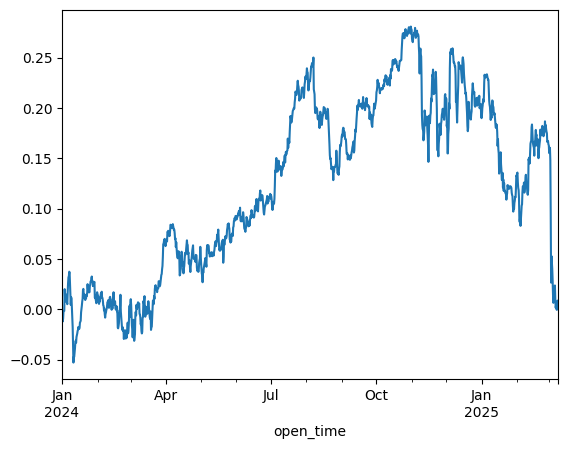

In [165]:
gross_return.cumsum().plot()

In [166]:
to = (port_positions.fillna(0) - port_positions.shift().fillna(0)).abs().sum(1)
to

open_time
2024-01-01 00:00:00    1.000000
2024-01-01 08:00:00    0.166667
2024-01-01 16:00:00    0.666667
2024-01-02 00:00:00    1.000000
2024-01-02 08:00:00    1.500000
                         ...   
2025-03-07 08:00:00    0.000000
2025-03-07 16:00:00    0.444444
2025-03-08 00:00:00    0.222222
2025-03-08 08:00:00    0.666667
2025-03-08 16:00:00    0.000000
Freq: 8h, Length: 1299, dtype: float64

In [167]:
tcost_bps = 20 # (commissions + slip)
net_ret = gross_return.subtract(to*tcost_bps*1e-4,fill_value=0)
net_ret

open_time
2024-01-01 00:00:00   -0.002000
2024-01-01 08:00:00   -0.009308
2024-01-01 16:00:00   -0.004505
2024-01-02 00:00:00    0.000750
2024-01-02 08:00:00    0.003828
                         ...   
2025-03-07 08:00:00   -0.003229
2025-03-07 16:00:00   -0.001928
2025-03-08 00:00:00    0.002919
2025-03-08 08:00:00    0.004548
2025-03-08 16:00:00   -0.002379
Freq: 8h, Length: 1299, dtype: float64

<Axes: xlabel='open_time'>

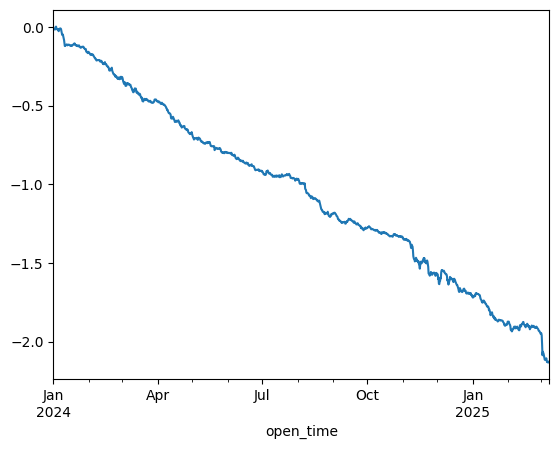

In [168]:
net_ret.cumsum().plot()

In [169]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-8.01536741267166